## 获取数据 | 计算兴趣点 | 创建网格 | 兴趣点fit网格 : 可达性 | 做图

### walking accessbility

In [42]:
#### 兴趣点是学校,算的实际是距离学校步行距离的远近,越近,可达性越高,最后的图像颜色越浅,可达性越高

#### 1_下载和加载网络数据

In [ ]:
# # import osmnx as ox
# # 设置地点名称
# place_name = 'Seattle, Washington, USA' # 自行输入想要的城市

# # 下载自行车网络
# walk_network = ox.graph_from_place(place_name,network_type = 'walk') # 或者其他,bike也可

# # 因为上一步往往花费时间较长,所以建议做好后存一下
# ox.save_graphml(walk_network,'walk_network.graphml')

#### 2_加载或生成兴趣点数据

In [3]:
import pandana as pdna

In [4]:
import pandas as pd

In [5]:
from pandana.loaders import osm

In [6]:
import numpy as np

In [7]:
import osmnx as ox

In [9]:
# bbox: 区域的边界框
bbox = [47.495,-122.435,47.734,-122.235]
minute = 30
amentity = 'school'
distance = minute * 83.33  # 人平均步行速度大约为5km/h -> 83.33m/minute

# osm.node_query：从 OpenStreetMap 下载指定区域和设施类型的节点数据。
pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags='"amenity"="{}"'.format(amenity))

In [11]:
pois[['amenity', 'name', 'lat', 'lon']].tail()

,amenity,name,lat,lon
id,,,,
11923813626,school,St. George Parish School,47.556294,-122.316436
12103109371,school,Neo Art School,47.663832,-122.331193
12340950975,school,The Hatch School,47.616085,-122.308396
12481057497,school,Mingyuan Evergreen Chinese School,47.701378,-122.294445
12750787938,school,Tilden School,47.566168,-122.387349


#### 3_创建网络对象

In [12]:
# 使用osmnx库从GraphML文件加载步行网络数据
walk_network = ox.load_graphml('walk_network.graphml')
nodes,edges = ox.graph_to_gdfs(walk_network)

In [15]:
nodes.head()

,y,x,highway,street_count,ref,geometry
osmid,,,,,,
29449863,47.644000,-122.303978,traffic_signals,4,NaN,POINT (-122.30398 47.644)
29462909,47.641088,-122.297930,NaN,3,NaN,POINT (-122.29793 47.64109)
29464223,47.643951,-122.304143,traffic_signals,3,NaN,POINT (-122.30414 47.64395)
29464742,47.658325,-122.301425,NaN,3,NaN,POINT (-122.30143 47.65832)
29464746,47.656011,-122.302121,NaN,3,NaN,POINT (-122.30212 47.65601)


In [16]:
edges.head()

osmid  oneway   lanes  \
u        v           key                                                        
29449863 3391701883  0                              332060236   False       3   
         10791184626 0                              424636850   False       2   
         29464223    0                              426250827   False       2   
         2247309277  0    [1230044737, 361443212, 1249280749]   False  [2, 4]   
29462909 3683076717  0                              364254479   False       2   

                             ref                            name    highway  \
u        v           key                                                      
29449863 3391701883  0    WA 513        East Montlake Place East  secondary   
         10791184626 0       NaN  East Lake Washington Boulevard  secondary   
         29464223    0       NaN                             NaN  secondary   
         2247309277  0    WA 513         Montlake Boulevard East    primary   
29462909 3683076717  0       NaN  Lake Washington Boulevard East  secondary   

                         maxspeed      junction reversed   length  \
u        v           key                                            
29449863 3391701883  0     25 mph  intersection     True    6.490   
         10791184626 0     25 mph           NaN     True    8.336   
         29464223    0        NaN  intersection    False   13.474   
         2247309277  0     30 mph           NaN    False  180.018   
29462909 3683076717  0     25 mph           NaN    False   17.682   

                                                                   geometry  \
u        v           key                                                      
29449863 3391701883  0    LINESTRING (-122.30398 47.644, -122.30394 47.6...   
         10791184626 0    LINESTRING (-122.30398 47.644, -122.30388 47.6...   
         29464223    0    LINESTRING (-122.30398 47.644, -122.30414 47.6...   
         2247309277  0    LINESTRING (-122.30398 47.644, -122.30404 47.6...   
29462909 3683076717  0    LINESTRING (-122.29793 47.64109, -122.29795 47...   

                         access bridge service width tunnel  
u        v           key                                     
29449863 3391701883  0      NaN    NaN     NaN   NaN    NaN  
         10791184626 0      NaN    NaN     NaN   NaN    NaN  
         29464223    0      NaN    NaN     NaN   NaN    NaN  
         2247309277  0      NaN    NaN     NaN   NaN    NaN  
29462909 3683076717  0      NaN    NaN     NaN   NaN    NaN

In [19]:
# 重置索引,将'u','v'转化为普通列
edges = edges.reset_index()
# 创建Pandana网络对象
walk_network = pdna.Network(
    nodes['x'],
    nodes['y'],
    edges['u'],
    edges['v'],
    edges[['length']]
)

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 126840
Setting CH edge vector of size 394238
Range graph removed 396862 edges of 788476
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


#### 4_计算可达性

In [22]:
# 预计算网络中每个节点在最大距离内的可达性查询结果。
# 使用 distance + 1 创建一个缓冲区可以确保计算涵盖了指定距离的所有区域。
walk_network.precompute(distance + 1)

# 初始化兴趣点引擎，设置类别和最大距离。
# num_categories=1 表示只定义了一个类别的兴趣点。
walk_network.init_pois(num_categories = 1,max_dist = distance,max_pois = 7)
# max_dist: 设置每个类别的最大搜索距离。
# max_pois: 设置每个兴趣点类别的最大兴趣点数量。

# 将兴趣点数据(经纬度)设置到网格中
walk_network.set_pois(category = 'my_amenity',x_col = pois['lon'],y_col = pois['lat'])

# 计算每个节点到最近兴趣点的距离。
access = walk_network.nearest_pois(distance = distance,category = 'my_amenity',num_pois = 7)
access.head()

Reading parameters from init_pois()
Reading parameters from init_pois()


,1,2,3,4,5,6,7
osmid,,,,,,,
29449863,2413.336914,2499.900000,2499.9,2499.9,2499.9,2499.9,2499.9
29462909,2206.529053,2499.900000,2499.9,2499.9,2499.9,2499.9,2499.9
29464223,2399.863037,2499.900000,2499.9,2499.9,2499.9,2499.9,2499.9
29464742,2082.430908,2289.448975,2499.9,2499.9,2499.9,2499.9,2499.9
29464746,2266.104004,2499.900000,2499.9,2499.9,2499.9,2499.9,2499.9


#### 5_数据可视化

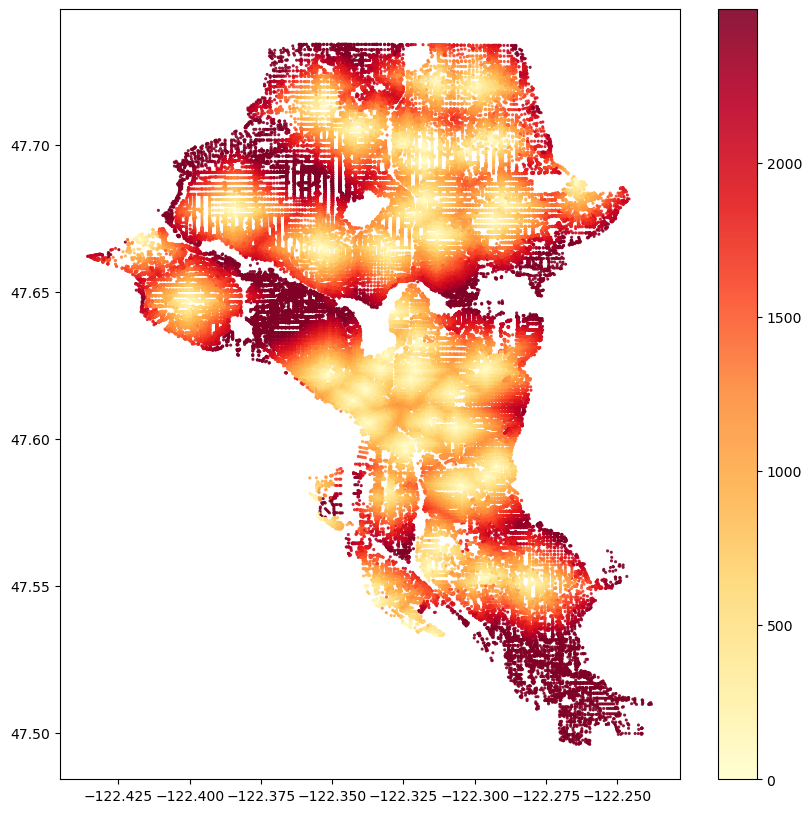

In [28]:
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
# fig_kwargs 和 plot_kwargs：设置图形和绘图的参数。
fig_kwargs = {
    'facecolor':'w',
    'figsize':(10,10)
}

# keyword arguments to pass for scatter plots
plot_kwargs = {
    's':5,
    'alpha':0.9,
    'cmap':'YlOrRd',
    'edgecolor':'none'
}

# plot the distance to the nth nearest amenity
n = 1 # N=1 到最近的XXX, N=5 到第五近的XXX。
fig, ax = walk_network.plot(access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
# access[1]所有节点到设施1号的距离
# fig.savefig('accessibility-all.png', dpi=200, bbox_inches='tight') #直接保存


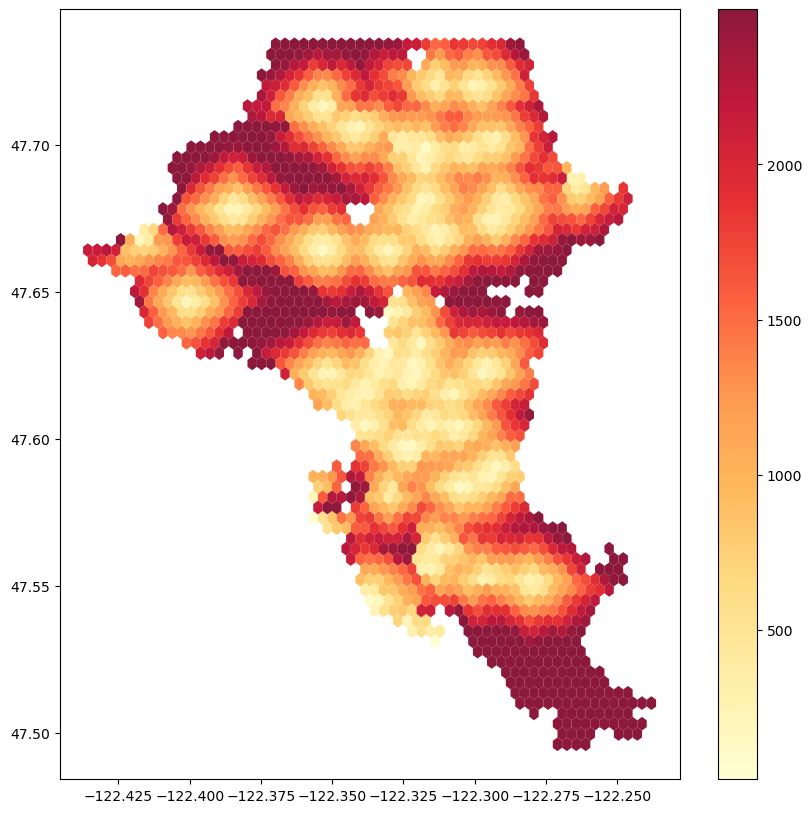

Text(0.5, 1.0, 'Walking distance (m) to nearest school')

In [31]:
# 设置六边形的PLOT
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'YlOrRd', 
                   'edgecolor':'none'}
cbar_kwargs = {}
fig, ax =  walk_network.plot(access[1], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor('k')
ax.set_title('Walking distance (m) to nearest school', fontsize=15)
#fig.savefig('accessibility-all-hexbin-east-bay.png', dpi=200, bbox_inches='tight') #直接保存
# plt.show()

### biking accessbility

#### 1_下载和加载网络数据

In [34]:
# # import osmnx as ox
# # 设置地点名称
# place_name = 'Seattle, Washington, USA' # 自行输入想要的城市

# # 下载自行车网络
# bike_network = ox.graph_from_place(place_name,network_type = 'bike') # 或者其他,bike也可

# # 因为上一步往往花费时间较长,所以建议做好后存一下
# ox.save_graphml(bike_network,'bike_network.graphml')

#### 2_加载或生成兴趣点数据

In [35]:
bbox = [47.495,-122.435,47.734,-122.235]
minute = 30
amentity = 'grocery'
distance = minute * 200

pois = osm.node_query(bbox[0],bbox[1],bbox[2],bbox[3],tags='"amenity"="{}"'.format(amenity))

#### 3_创建网络对象

In [38]:
bike_network = ox.load_graphml('bike_network.graphml')
nodes,edges = ox.graph_to_gdfs(bike_network)
edges.head(5)

osmid  oneway   lanes  \
u        v           key                                                        
29449863 29464223    0                              426250827    True       2   
         2247309277  0    [1230044737, 361443212, 1249280749]    True  [2, 4]   
29462909 59677221    0                              364254479   False       2   
         59710181    0                 [364254484, 364254479]   False       2   
         10799990961 0                [1036136081, 433070538]   False     NaN   

                            highway      junction reversed   length     ref  \
u        v           key                                                      
29449863 29464223    0    secondary  intersection    False   13.474     NaN   
         2247309277  0      primary           NaN    False  180.018  WA 513   
29462909 59677221    0    secondary           NaN    False   51.035     NaN   
         59710181    0    secondary           NaN     True   87.325     NaN   
         10799990961 0      service           NaN    False  356.089     NaN   

                                                    name maxspeed  \
u        v           key                                            
29449863 29464223    0                               NaN      NaN   
         2247309277  0           Montlake Boulevard East   30 mph   
29462909 59677221    0    Lake Washington Boulevard East   25 mph   
         59710181    0    Lake Washington Boulevard East   25 mph   
         10799990961 0                               NaN      NaN   

                                                                   geometry  \
u        v           key                                                      
29449863 29464223    0    LINESTRING (-122.30398 47.644, -122.30414 47.6...   
         2247309277  0    LINESTRING (-122.30398 47.644, -122.30404 47.6...   
29462909 59677221    0    LINESTRING (-122.29793 47.64109, -122.29795 47...   
         59710181    0    LINESTRING (-122.29793 47.64109, -122.29786 47...   
         10799990961 0    LINESTRING (-122.29793 47.64109, -122.29784 47...   

                         access bridge service tunnel width  
u        v           key                                     
29449863 29464223    0      NaN    NaN     NaN    NaN   NaN  
         2247309277  0      NaN    NaN     NaN    NaN   NaN  
29462909 59677221    0      NaN    NaN     NaN    NaN   NaN  
         59710181    0      NaN    NaN     NaN    NaN   NaN  
         10799990961 0       no    yes     NaN    NaN   NaN

In [39]:
edges = edges.reset_index()

In [40]:
bike_network = pdna.Network(
    nodes['x'],
    nodes['y'],
    edges['u'],
    edges['v'],
    edges[['length']]
)

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 56395
Setting CH edge vector of size 139798
Range graph removed 130738 edges of 279596
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


#### 4_计算可达性

In [45]:
bike_network.precompute(distance + 1)
# 设计网格上的poi,即初始化引擎
bike_network.init_pois(num_categories = 1,max_dist = distance,max_pois = 7)
# 将兴趣点数据设置到网格中
bike_network.set_pois(category = 'my_amenity',x_col = pois['lon'],y_col = pois['lat'])
# 计算每个节点到最近兴趣点的距离。
access = bike_network.nearest_pois(distance = distance,category = 'my_amenity',num_pois = 7)
access.head()

Reading parameters from init_pois()
Reading parameters from init_pois()


,1,2,3,4,5,6,7
osmid,,,,,,,
29449863,2521.928955,2633.366943,2985.850098,3169.305908,3564.450928,3580.867920,3743.622070
29462909,2332.318115,2715.232910,3179.154053,3469.836914,3486.253906,3649.008057,3835.634033
29464223,2520.061035,2639.129883,2983.981934,3176.143066,3570.214111,3586.631104,3749.385010
29464742,2093.491943,2318.266113,3112.719971,3252.441895,3262.017090,3489.490967,3953.300049
29464746,2355.995117,2580.769043,3375.222900,3514.945068,3524.520020,3709.340088,3751.993896


#### 5_数据可视化

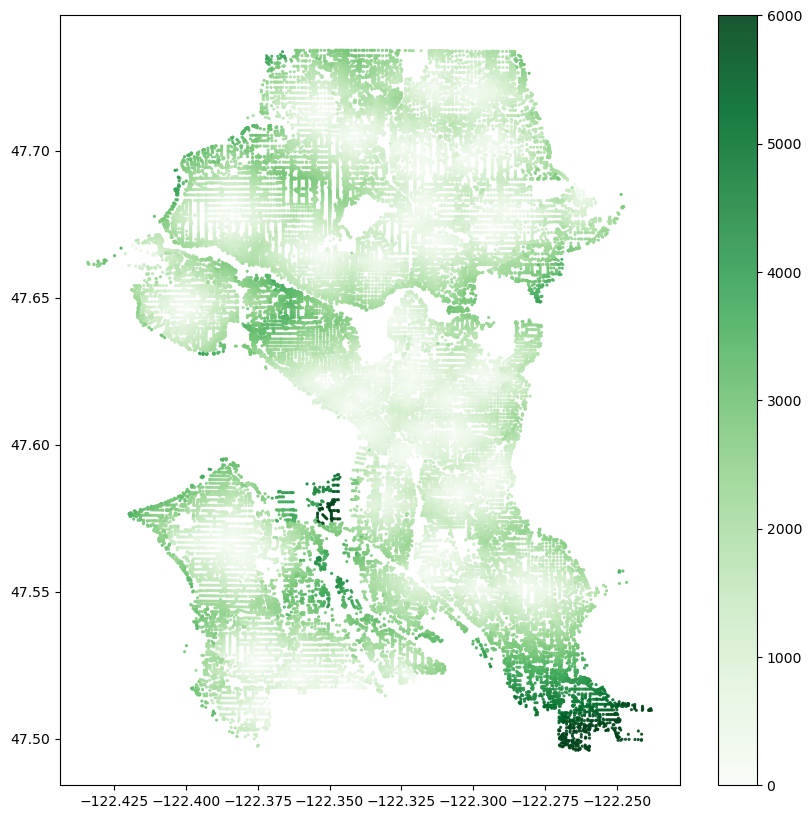

In [52]:
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
# fig_kwargs 和 plot_kwargs：设置图形和绘图的参数。
fig_kwargs = {
    'facecolor':'w',
    'figsize':(10,10)
}

# keyword arguments to pass for scatter plots
plot_kwargs = {
    's':5,
    'alpha':0.9,
    'cmap':'Greens',
    'edgecolor':'none'
}

# plot the distance to the nth nearest amenity
n = 1 # N=1 到最近的XXX, N=5 到第五近的XXX。
fig, ax = bike_network.plot(access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
# access[1]所有节点到设施1号的距离
# fig.savefig('accessibility-bike-grocery.png', dpi=200, bbox_inches='tight') #直接保存


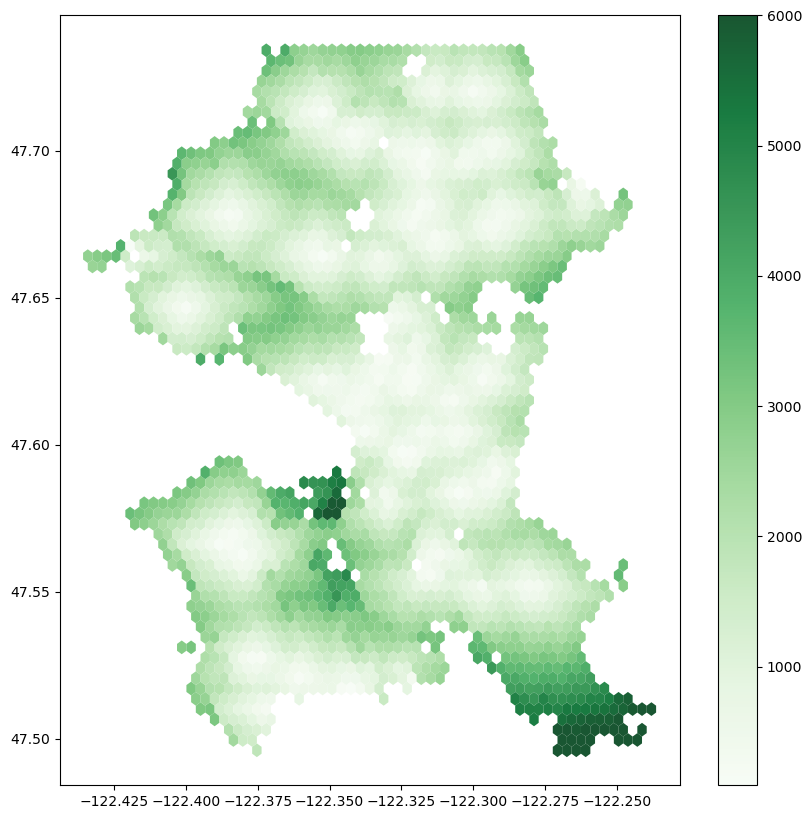

Text(0.5, 1.0, 'Biking distance (m) to nearest grocery')

In [54]:
# 设置六边形的PLOT
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'Greens', 
                   'edgecolor':'none'}
cbar_kwargs = {}
fig, ax =  bike_network.plot(access[1], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor('k')
ax.set_title('Biking distance (m) to nearest grocery', fontsize=15)
#fig.savefig('accessibility-all-hexbin-east-bay.png', dpi=200, bbox_inches='tight') #直接保存
# plt.show()

In [41]:
### 问题: 如何设置多个点的poi?

In [ ]:
# # 初始化兴趣点引擎，定义 3 个类别的兴趣点 
# walk_network.init_pois(num_categories=3, max_dist=distance, max_pois=7) 

# # 为每个类别设置兴趣点 
# walk_network.set_pois(category='grocery', x_col=poi_longitudes, y_col=poi_latitudes, category_index=0) 
# walk_network.set_pois(category='restaurant', x_col=restaurant_longitudes, y_col=restaurant_latitudes, category_index=1) 
# walk_network.set_pois(category='park', x_col=park_longitudes, y_col=park_latitudes, category_index=2)

In [55]:
# 为什么category是my_amenity而不是amenity?